## Exercise 06 : Scatter Matrix

### Import and connection

In [14]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

try:
  connect = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
  print('OK. Connected to sqlite')

except sqlite3.Error as error:
  print('Error with connection:', error)

OK. Connected to sqlite


Посмотрим, какие таблицы есть в базе test и control это таблицы, которые мы сами создали (выборки)

In [15]:
a = connect.cursor().execute('SELECT name from sqlite_master where type= "table"')
print(a.fetchall())

[('pageviews',), ('checker',), ('deadlines',)]


Создадим таблицу с количеством коммитов

In [16]:
query = '''
SELECT uid, COUNT(*) AS num_commits
FROM checker
WHERE uid LIKE 'user_%'
AND labname <> 'project1'
GROUP BY uid
'''
commits = pd.io.sql.read_sql(query, connect)
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


Создадим таблицу с количеством просмотров

In [17]:
query = '''
SELECT uid, COUNT(*) AS num_views
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY uid
'''
num_views = pd.io.sql.read_sql(query, connect)
num_views

,uid,num_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


Создадим таблицу с дельтой: разница между первым коммитом и дедлайном лаборатории (подробно, как мы это делали в Day06 ех03). (Не принимать во внимание project1 для расчета средней разницы и количества коммитов)

In [18]:
query = '''
SELECT uid,
       CAST((JulianDay(test.first_commit_ts) -
            JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))
                  ) * 24 AS Integer
           ) AS delta
FROM test
LEFT JOIN deadlines ON test.labname=deadlines.labs
WHERE labname <> 'project1'
'''
delta = pd.io.sql.read_sql(query, connect)
delta

DatabaseError: Execution failed on sql '
SELECT uid,
       CAST((JulianDay(test.first_commit_ts) -
            JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))
                  ) * 24 AS Integer
           ) AS delta
FROM test
LEFT JOIN deadlines ON test.labname=deadlines.labs
WHERE labname <> 'project1'
': no such table: test

Найдем среднюю дельту по каждому пользователю

In [19]:
delta = delta.groupby(['uid']).mean()

NameError: name 'delta' is not defined

Объединим все это в один датафрейм, в котором каждый пользователь тестовой группы имеет среднюю разницу между первым коммитом и дедлайном лаборатории, количество просмотров страниц и количество коммитов (не принимать во внимание project1 для расчета средней разницы и количества коммитов

In [20]:
pivot_table = num_views.merge(commits, on=['uid'])
pivot_table = delta.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = ['uid'])
pivot_table

NameError: name 'delta' is not defined

По диагоналям отображена плотность ядра (KDE). KDE - это непараметрический способ оценки функции плотности вероятности любой переменной.

ModuleNotFoundError: No module named 'scipy'

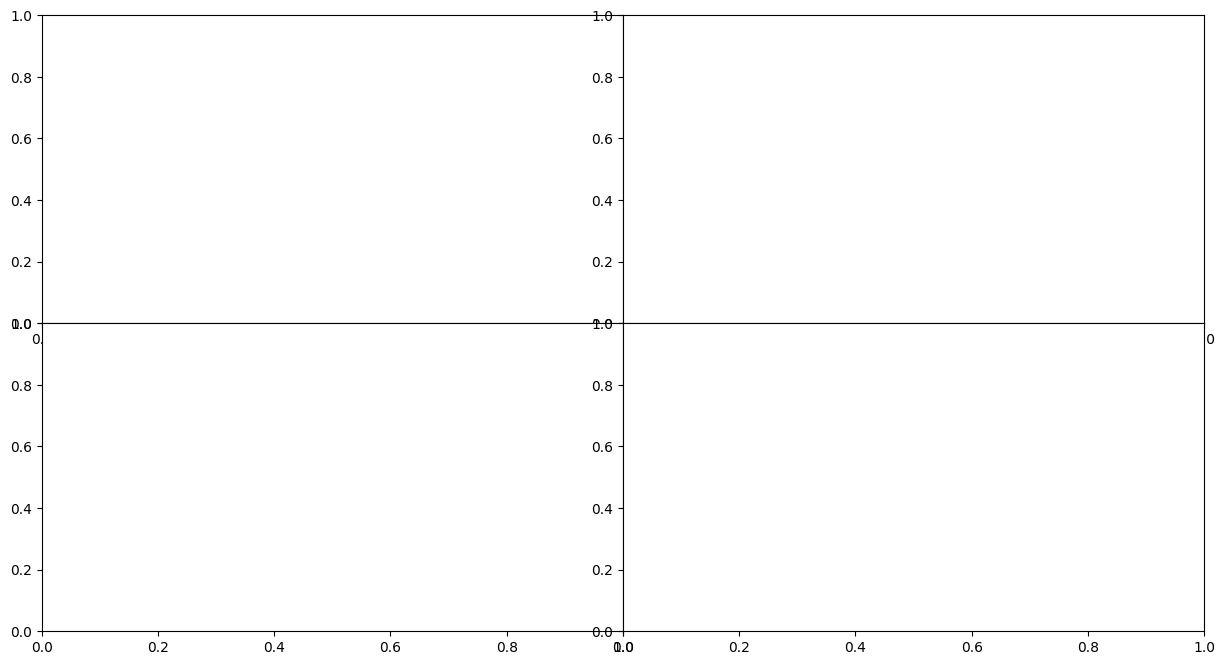

In [21]:
ax = scatter_matrix(pivot_table,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#059ABF', linewidth=3),
                    s=200,
                    color='red')

Можем ли мы сказать, что если у пользователя мало просмотров страниц, то он, скорее всего, у вас мало коммитов?

Нет

Можем ли мы сказать, что если у пользователя мало просмотров страниц, небольшая средняя разница между первым коммитом и крайним сроком лаборатории?

Нет

Можем ли мы сказать, что есть много пользователей с небольшим количеством коммитов и мало с большим количеством коммитов?

Можно сказать, что пользователей с небольшим количеством коммитов больше, чем с малым. Однако для вопроса много ли их, нужно понимать, какое значение мы примем за "много".

Можем ли мы сказать, что есть много пользователей с небольшой средней разницей и несколько с большой средней разницей?

Нет, но как и в предудыщем случае встает вопрос: какое значение мы примем за "много".

### Close the connection

In [22]:
connect.close()
print('Connection to SQLite closed')

Connection to SQLite closed
